### Deep Learningによる傾向分析
* チャート画像を入力し、上昇/停滞/下降の3パターンのいずれになるかを予測する。
* ここでは、上記を実現するモデルとして、Vgg16を用いる。

In [1]:
import pandas as pd
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import os

class _CsvFileDataset(Dataset):
    """
    csvデータからデータセットの読み込み
    
    Attributes
    ----------
    transform : torchvision.transforms
        前処理用の関数
    pathes : list of str
        画像データのpathのリスト
    targets : list of int
        クラスラベルのリスト
    """
    
    def __init__(self, csv_file, root_dir='.', transform=None):
        """
        コンストラクタ
        
        Parameters
        ----------
        csv_file : str (extension: .csv)
            csvファイル
        transform : torchvision.transforms
            前処理用の関数
        """
        self.transform = transform
        # csvファイルの読み込み
        df = pd.read_csv(csv_file, engine='python')
        df['target_path'] = df['path'].map(lambda path: os.path.join(root_dir, path))
        # 画像データのpathとclassを取得（有効なpathのみ）
        target_df = df[df['target_path'].apply(lambda path: os.path.exists(path))].copy()
        self.pathes = target_df['target_path'].to_list()
        self.targets = list(map(int, target_df['class'].to_list()))
    
    def __getitem__(self, index):
        """
        画像データの取得
        
        Parameters
        ----------
        index : int
            データ取得時のインデックス

        Returns
        -------
        sample : torch.Tensor
            画像データ
        target : int
            ラベルデータ
        """
        path, target = self.pathes[index], self.targets[index]
        # PIL形式で画像データを読み込む
        img = Image.open(path)
        sample = img.convert('RGB')
        # 変換
        if self.transform is not None:
            sample = self.transform(sample)

        return sample, target
    
    def __len__(self):
        """
        データセットのサイズの取得
        
        Returns
        -------
        data_size : int
            データセットのサイズ
        """
        data_size = len(self.targets)

        return data_size
    
class CreateDataLoader():
    """
    データローダの生成
    
    Attributes
    ----------
    root_dir : str
        ルートディレクトリ
    batch_size : int
        バッチサイズ
    transform : torchvision.transform
        前処理用の関数
    """

    def __init__(self, root_dir='.', batch_size=64):
        """
        コンストラクタ
        Parameters
        ----------
        batch_size
            バッチサイズ
        """
        self.root_dir = root_dir
        self.batch_size = batch_size
        self.transform = transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
        ])

    def get_dataloader(self, csv_file, is_shuffle=False, num_workers=2):
        """
        データローダの取得
        
        Parameters
        ----------
        csv_metafile : str
            データセットのcsvファイル名
        is_shuffle : bool
            シャッフルの有無
        num_workers : int
            並列数
            
        Returns
        -------
        dataloader : DataLoader
            データセットのデータローダ
        """
        # データセットの定義
        dataset = _CsvFileDataset(csv_file, root_dir=self.root_dir, transform=self.transform)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=is_shuffle, num_workers=num_workers, pin_memory=True)

        return dataloader

In [2]:
import torch
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time

class Network():
    """
    分類に用いるネットワーク
    
    Attributes
    ----------
    device : torch.device
        利用するデバイス
    model : nn.Module
        利用するモデル
    optimizer : optim.Adam
        利用する最適化手法
    criterion : nn.CrossEntropyLoss
        利用する損失関数
    """
    
    def __init__(self, device, num_classes):
        """
        コンストラクタ
        
        Parameters
        ----------
        device : torch.device
            利用するデバイス
        num_classes : int
            出力層のクラスサイズ
        """
        model = models.vgg16(pretrained=True)
        num_features = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_features, num_classes) # 全結合層（FC層）の出力クラス数を変更
        self.device = device
        self.model = model.to(self.device)
        self.optimizer = optim.SGD(self.model.parameters(), lr=1e-3, momentum=0.9)
        self.criterion = nn.CrossEntropyLoss()
        
    def execute(self, train_loader, test_loader, max_epoch, result_filename):
        """
        学習とテストの実施
        
        Parameters
        ----------
        train_loader : DataLoader
            学習用データセット
        test_loader : DataLoader
            テスト用データセット
        max_epoch : int
            最大エポック数
        result_filename : str
            損失関数値と精度の結果の保存先
            
        Returns
        -------
        best_params : dict
            学習により得られた最適なパラメータ
        """

        best_accuracy = -1
        best_params = self.model.state_dict()
        
        with open(result_filename, 'w') as f_loss:
            f_loss.write('epoch,train_loss,train_accuracy,test_loss,test_accuracy\n')
            
            for epoch in np.arange(1, max_epoch + 1):
                # 学習実施
                start_time = time.time()
                train_loss, train_accuracy = self.__train(train_loader, epoch)
                elapsed_time = time.time() - start_time
                # テスト実施
                test_loss, test_accuracy = self.__test(test_loader, epoch)
                f_loss.write('{},{},{},{},{}\n'.format(epoch, train_loss, train_accuracy, test_loss, test_accuracy))
                print('=== Epoch: {} (Time: {}[sec]) ==='.format(epoch, elapsed_time))
                print('Train loss: {:.4e}, Train accuracy: {:.3%}'.format(train_loss, train_accuracy))
                print('Test  loss: {:.4e}, Test  accuracy: {:.3%}'.format(test_loss, test_accuracy))
                print('=================\n')

                if test_accuracy > best_accuracy:
                    best_accuracy = test_accuracy
                    best_params = self.model.state_dict()

        return best_params

    def __train(self, train_loader, epoch):
        """
        学習実施
        
        Parameters
        ----------
        train_loader : DataLoader
            学習用データセット
        epoch : int
            エポック数

        Returns
        -------
        epoch_loss : float
            学習時の平均損失値
        accuracy : float
            正解率
        """
        
        # モデルを学習用に設定
        self.model.train()
        # 出力回数
        output_num = 5
        # 出力間隔
        output_interval = len(train_loader) // output_num
        if output_interval < 1:
            output_interval = 1
        # 変数の初期化
        epoch_loss = 0
        correct = 0
        num_total = 0
        
        for batch_idx, (inputs, targets) in enumerate(train_loader, 1):
            # 利用するデバイス向けにデータを変換
            inputs = inputs.to(self.device)
            targets = targets.to(self.device).long()
            
            # 勾配の初期化
            self.optimizer.zero_grad()
            # 順伝播処理
            outputs = self.model(inputs)
            # 損失関数の計算
            loss = self.criterion(outputs, targets)
            # 逆伝播
            loss.backward()
            # パラメータ更新
            self.optimizer.step()
            
            # 予測結果の集計
            loss_val = loss.item()
            epoch_loss += loss_val
            _, predicted = torch.max(outputs.data, 1)
            num_total += targets.size(0)
            correct += predicted.eq(targets.data).cpu().sum().item()
            
            if batch_idx % output_interval == 0:
                    print('Train Epoch: {} [{}/{}({:.0%})] Loss: {:.4e}'.format(
                        epoch, num_total, len(train_loader.dataset), batch_idx / len(train_loader), loss_val)
                    )
                    
        epoch_loss /= len(train_loader)
        accuracy = correct / num_total
        
        return epoch_loss, accuracy
    
    def __test(self, test_loader, epoch):
        """
        テスト実施
        
        Parameters
        ----------
        test_loader : DataLoader
            テスト用データセット
        epoch : int
            エポック数
            
        Returns
        -------
        epoch_loss : float
            テスト時の平均損失値
        accuracy : float
            正解率
        """
        
        with torch.no_grad():
            # モデルを評価用に設定
            self.model.eval()
            
            # 変数の初期化
            epoch_loss = 0
            correct = 0
            num_total = 0

            for (inputs, targets) in test_loader:
                # 利用するデバイス向けにデータを変換
                inputs = inputs.to(self.device)
                targets = targets.to(self.device).long()

                # 順伝播処理
                outputs = self.model(inputs)
                # 損失関数の計算
                loss = self.criterion(outputs, targets)
                
                # 予測結果の集計
                epoch_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                num_total += targets.size(0)
                correct += predicted.eq(targets.data).cpu().sum().item()

            epoch_loss /= len(test_loader)
            accuracy = correct / num_total
            
        return epoch_loss, accuracy

In [3]:
import torch
import numpy as np
import random
seed = 1
# デバイス名と乱数の初期値の設定
np.random.seed(seed=seed)
random.seed(seed)
if torch.cuda.is_available():
    device_name = 'cuda'
    torch.cuda.manual_seed_all(seed)
else:
    device_name = 'cpu'
    torch.cuda.manual_seed(seed)
device = torch.device(device_name)

# ==================
# データセットの定義
# ==================
root_dir = '.'
train_filename = 'train_dataset.csv'
test_filename = 'test_dataset.csv'
dataloader_creater = CreateDataLoader(root_dir=root_dir, batch_size=128)
train_loader = dataloader_creater.get_dataloader(train_filename, is_shuffle=True)
test_loader = dataloader_creater.get_dataloader(test_filename, is_shuffle=False)

# =============
# Networkの定義
# =============
num_classes = 3
net = Network(device, num_classes)

In [4]:
# ================
# 学習と評価の実施
# ================
max_epoch = 2
result_filename = 'result_loss.csv'
best_params = net.execute(train_loader, test_loader, max_epoch, result_filename)

Train Epoch: 1 [1536/7750(20%)] Loss: 1.0993e+00
Train Epoch: 1 [3072/7750(39%)] Loss: 1.1194e+00
Train Epoch: 1 [4608/7750(59%)] Loss: 1.0874e+00
Train Epoch: 1 [6144/7750(79%)] Loss: 1.1301e+00
Train Epoch: 1 [7680/7750(98%)] Loss: 1.1439e+00
=== Epoch: 1 (Time: 639.7073101997375[sec]) ===
Train loss: 1.1398e+00, Train accuracy: 33.729%
Test  loss: 1.1574e+00, Test  accuracy: 32.500%

Train Epoch: 2 [1536/7750(20%)] Loss: 1.0402e+00
Train Epoch: 2 [3072/7750(39%)] Loss: 1.1014e+00
Train Epoch: 2 [4608/7750(59%)] Loss: 1.1117e+00
Train Epoch: 2 [6144/7750(79%)] Loss: 1.0801e+00
Train Epoch: 2 [7680/7750(98%)] Loss: 1.0766e+00
=== Epoch: 2 (Time: 641.5892572402954[sec]) ===
Train loss: 1.0809e+00, Train accuracy: 40.323%
Test  loss: 1.1180e+00, Test  accuracy: 33.846%



In [5]:
# モデルの出力
print(net.model)
# ======================
# モデルパラメータの保存
# ======================
torch.save(best_params, 'resnet18.pth')

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Text(0.5, 1.0, 'Accuracy')

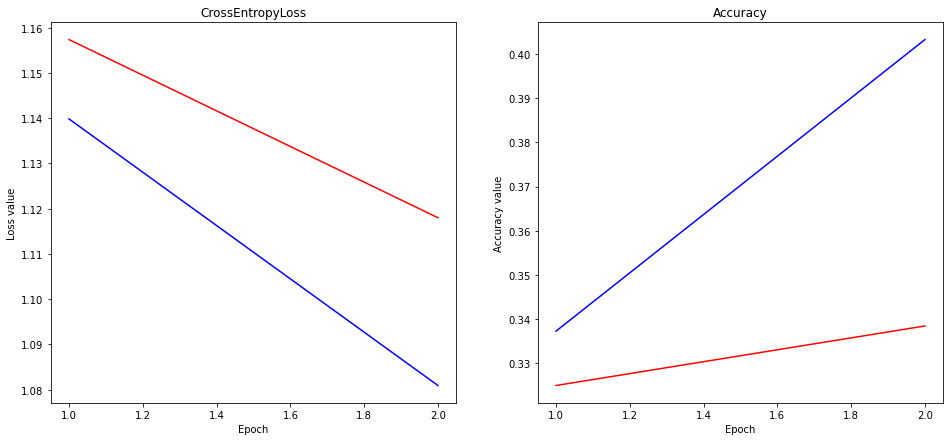

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv(result_filename)
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
axes = axes.flatten()

# loss function
ax = axes[0]
ax.plot(df['epoch'], df['train_loss'], '-b')
ax.plot(df['epoch'], df['test_loss'],  '-r')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss value')
ax.set_title('CrossEntropyLoss')

# accuracy
ax = axes[1]
ax.plot(df['epoch'], df['train_accuracy'], '-b')
ax.plot(df['epoch'], df['test_accuracy'],  '-r')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy value')
ax.set_title('Accuracy')